# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python


2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

In [3]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [8]:
cursor = con.cursor()

sql = """
SELECT max(hire_date), min(hire_date)
FROM employees
"""

In [9]:
cursor.execute(sql)
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

In [10]:
cursor.close()

True

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП. 

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [11]:
cursor = con.cursor()

sql_1 = """
SELECT emp_no, salary, from_date, to_date
FROM salaries as s
WHERE from_date = (select max(from_date) from salaries as sl where s.emp_no = sl.emp_no)
"""

cursor.execute(sql_1)
result = cursor.fetchall()
cursor.close()

True

In [12]:
import pandas as pd

In [13]:
field_names = [i[0] for i in cursor.description]

In [14]:
res = pd.DataFrame(result, columns=field_names)
display(res.columns, res.shape, res.head(3))

Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

(300024, 4)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


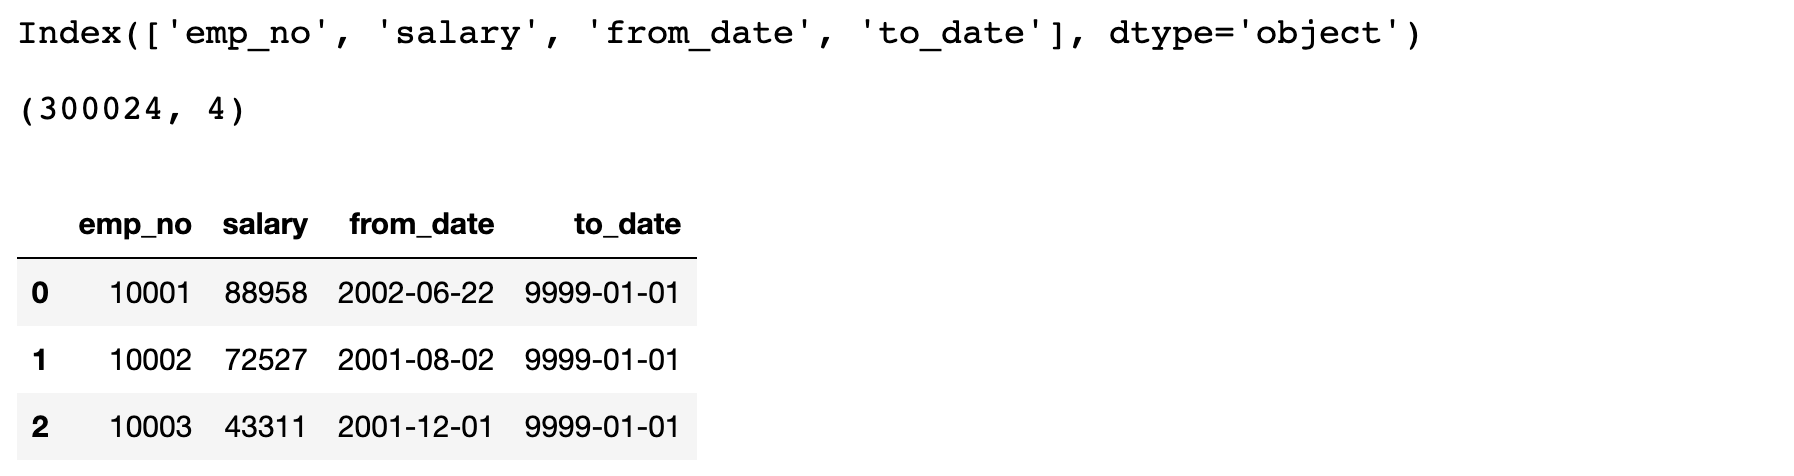

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [15]:
res.dtypes

emp_no        int64
salary        int64
from_date    object
to_date      object
dtype: object

In [46]:
res['to_date'] = res['to_date'].astype(str)
# хоча метод dtypes показує, що колонка to_date має тип даних object, але при фільтрації по '9999-01-01' видає пуcтий датафрейм
# OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 9999-01-01 00:00:00 present at position 0


In [57]:
emp_current = res[res['to_date'] == '9999-01-01']
ex_emp_n = res[res['to_date'] != '9999-01-01']['to_date'].count()
print(f'to date == 9999-01-01 = {emp_current["to_date"].count()} значень\nto_date != 9999-01-01 = {ex_emp_n} значень')

to date == 9999-01-01 = 240124 значень
to_date != 9999-01-01 = 59900 значень


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

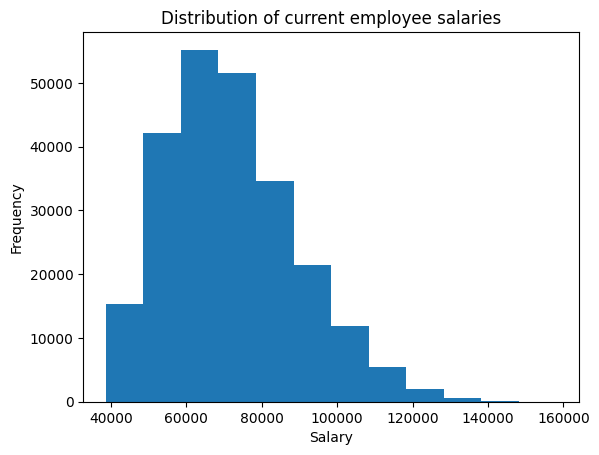

In [45]:
import matplotlib.pyplot as plt

plt.hist(emp_current['salary'], bins=12);

plt.title('Distribution of current employee salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency');

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [34]:
sql_2 = """
SELECT year(hire_date) as hire_year, count(1) as emp_num
FROM employees
group by hire_year

"""

In [42]:
df = pd.read_sql(sql_2, con)
df

,hire_year,emp_num
0,1986,36150
1,1985,35316
2,1989,28394
3,1994,14835
4,1990,25610
5,1992,20402
6,1987,33501
7,1995,12115
8,1993,17772
9,1999,1514


Очікуваний результат:

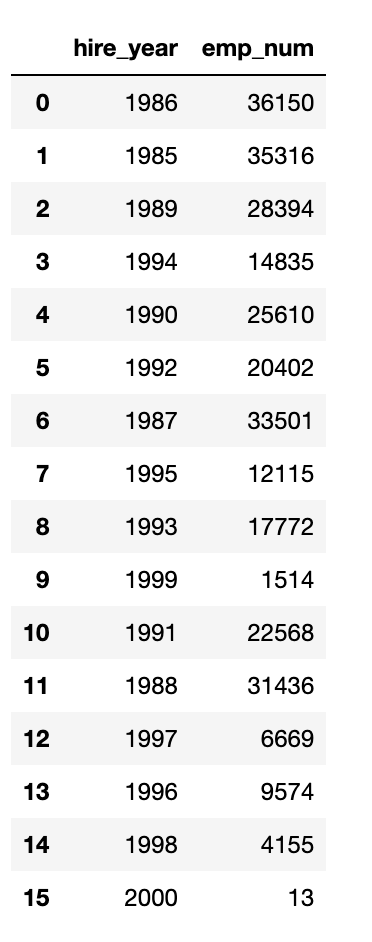

8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

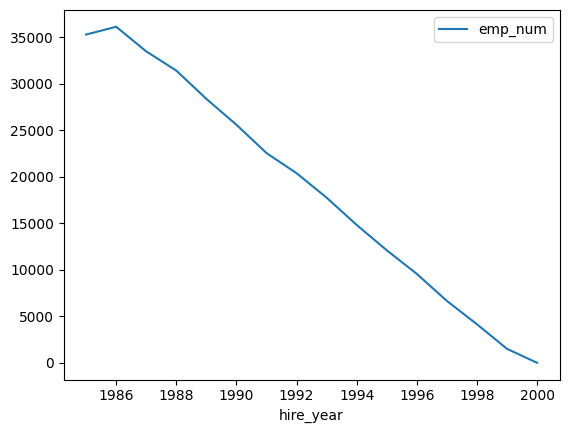

In [36]:
df.sort_values(by='hire_year').plot(x='hire_year', y='emp_num');

Очікуваний результат:

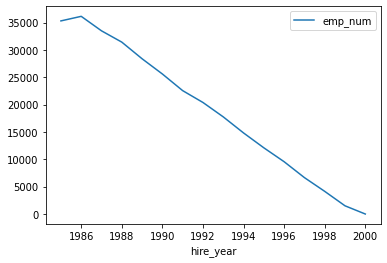

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [40]:
import warnings

warnings.filterwarnings('ignore')

In [37]:
sql_3 = """
SELECT TIMESTAMPDIFF(YEAR, from_date, to_date) as duration, from_date, to_date
FROM titles
where title = 'Engineer' AND to_date is not null AND to_date != '9999-01-01'

"""

In [41]:
df_years = pd.read_sql(sql_3, con)
df_years

,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


Очікуваний результат:

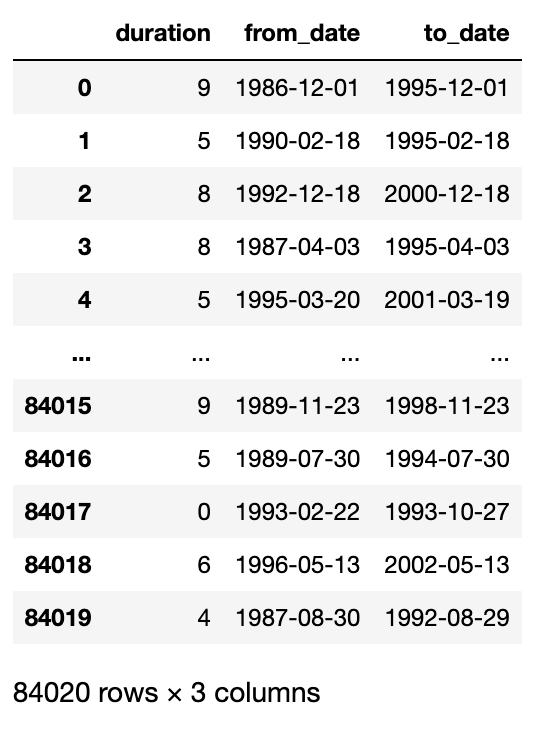

10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

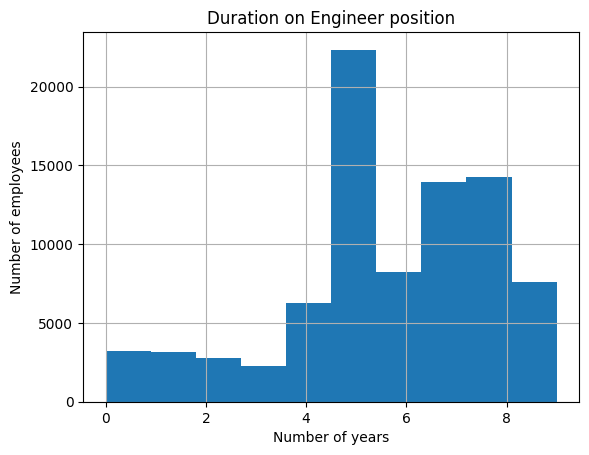

In [39]:
df_years.hist();

plt.title('Duration on Engineer position')
plt.xlabel('Number of years')
plt.ylabel('Number of employees');

Очікуваний результат:

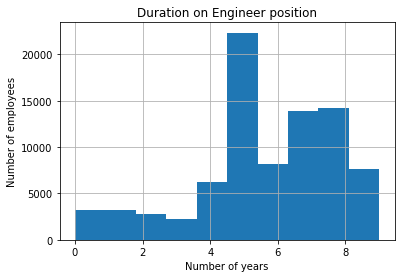

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [58]:
con.close()